https://colab.research.google.com/drive/1Zp2b1vAQ_iKrLbQsg24AdF8H7zXTTGHU#scrollTo=LnKaW2adeGfw

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
import numpy as np
import pandas as pd
import datetime
#from adbrew_core.settings import db
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
tf.random.set_seed(1)
np.random.seed(1)
import warnings
warnings.filterwarnings("ignore")

In [40]:
df = pd.read_csv("/content/drive/MyDrive/colab/account_data.csv",parse_dates = True)

In [41]:
a = list(df['accountId'].unique())

In [42]:
df = df[df['accountId']=="5ffdb895b08512986422b08c"]

In [43]:
df=df.copy()
df.date = pd.to_datetime(df.date)
df.sort_values(by="date", inplace=True, ignore_index=True)
account_data = df

In [44]:
keyword_ids = account_data["keywordId"].unique()
keywordwise_sales = account_data.groupby("keywordId")["sales"].sum()
nonzero_sales_keywords = keywordwise_sales[keywordwise_sales>0]
nonzero_sales_keywords.sort_values(ascending=False, inplace=True)
keywords_req = list(nonzero_sales_keywords.index)
keyword_ids = keywords_req[:10]
account_data =  account_data[account_data['keywordId'].isin(keyword_ids)]

In [45]:
account_data.reset_index(inplace = True)
account_data.sort_values(by="date", inplace=True, ignore_index=True)
account_data.drop(columns = "index",inplace = True)
account_data.sort_values(by = 'date',inplace = True)
account_data.reset_index(inplace = True)
account_data.drop(columns = "index",inplace = True)
account_data['clicks'] = account_data["clicks"].astype("int64")
account_data['impressions'] = account_data["impressions"].astype("int64")
account_data['orders'] = account_data["orders"].astype("int64")
account_data["keywordId"] = account_data["keywordId"].astype(str)
account_data["cpc"] = account_data["spend"]/account_data["clicks"] 
account_data["cpc"].interpolate("linear", inplace=True)

In [46]:
#account_data

In [47]:
keyword_ids = account_data['keywordId'].unique()

In [48]:
keyword_wise_df = pd.DataFrame(columns = [['accountId', 'adGroupId', 'campaignId', 'keywordId', 'date', 'sales','spend', 'clicks', 'impressions', 'orders', 'cpc']])

In [49]:
keyword_wise_df

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cpc


In [50]:
account_data[account_data["keywordId"] == keyword_ids[0]].head(2)

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cpc
0,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-20,142838.120000,12583.680000,1281,29878,111,9.823326
9,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-21,116525.377143,10593.249643,1168,25691,85,9.069563


In [51]:
frames_train = []
for i in range(len(keyword_ids)):
     a = int((40*len(account_data[account_data['keywordId'] == keyword_ids[i]]))/100)
     b = len(account_data[account_data['keywordId'] == keyword_ids[i]]) - a
     new_df_i = account_data[account_data['keywordId'] == keyword_ids[i]][:b]
     frames_train.append(new_df_i)

In [52]:
new_df = pd.concat(frames_train)

In [53]:
new_df.shape

(1721, 11)

In [54]:
new_df

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cpc
0,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-20,142838.120000,12583.680000,1281,29878,111,9.823326
9,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-21,116525.377143,10593.249643,1168,25691,85,9.069563
17,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-22,112508.444448,9819.077878,1158,26380,85,8.479342
24,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-23,113365.773241,9397.466625,1170,27465,83,8.032023
32,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-24,108217.496805,8806.986435,1136,27727,81,7.752629
...,...,...,...,...,...,...,...,...,...,...,...
1973,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2022-09-30,25872.236609,1439.157108,219,16509,20,6.571494
1981,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2022-10-01,23591.303726,1319.580160,205,15784,18,6.436976
1989,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2022-10-02,21309.636561,1214.248138,191,15459,16,6.357320
1999,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2022-10-03,19185.413018,1130.548387,180,14823,15,6.280824


In [55]:
new_df.reset_index(inplace = True)

In [56]:
new_df.drop(columns ="index", inplace = True)

In [57]:
new_df[new_df['cpc'] != max(new_df['cpc'])]

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cpc
0,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-20,142838.120000,12583.680000,1281,29878,111,9.823326
1,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-21,116525.377143,10593.249643,1168,25691,85,9.069563
2,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-22,112508.444448,9819.077878,1158,26380,85,8.479342
3,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-23,113365.773241,9397.466625,1170,27465,83,8.032023
4,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-24,108217.496805,8806.986435,1136,27727,81,7.752629
...,...,...,...,...,...,...,...,...,...,...,...
1716,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2022-09-30,25872.236609,1439.157108,219,16509,20,6.571494
1717,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2022-10-01,23591.303726,1319.580160,205,15784,18,6.436976
1718,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2022-10-02,21309.636561,1214.248138,191,15459,16,6.357320
1719,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2022-10-03,19185.413018,1130.548387,180,14823,15,6.280824


In [58]:
mean_cpc = sum(new_df[new_df['cpc'] != max(new_df['cpc'])]['cpc'])/len(new_df[new_df['cpc'] != max(new_df['cpc'])])

In [59]:
new_df['cpc'] = new_df['cpc'].astype(str)

In [60]:
new_df.dtypes

accountId              object
adGroupId               int64
campaignId              int64
keywordId              object
date           datetime64[ns]
sales                 float64
spend                 float64
clicks                  int64
impressions             int64
orders                  int64
cpc                    object
dtype: object

In [61]:
new_df.replace({"cpc":{"inf":mean_cpc}},inplace = True)

In [62]:
new_df['cpc'] = new_df['cpc'].astype(float)

In [63]:
max(new_df['cpc'])

33.37953149076742

In [64]:
account_data = new_df

In [65]:
account_data.shape

(1721, 11)

In [66]:
min(account_data['spend'])

0.0

In [67]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(account_data[['sales','spend', 'clicks', 'impressions', 'orders','cpc']])
dataY = y_scaler.fit_transform(account_data[['sales','spend']])

In [68]:
def create_dataset(dataset, time_step):
    import numpy
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [69]:
x_train_multi,y_train_multi = create_dataset(dataX,14)
x_val_multi, y_val_multi = create_dataset(dataY,14)

In [70]:
# reshape input to be [samples, time steps, features] which is required for LSTM
x_train_multi =x_train_multi.reshape(x_train_multi.shape[0],x_train_multi.shape[1] , 1)
x_val_multi = x_val_multi.reshape(x_val_multi.shape[0],x_val_multi.shape[1] , 1)

In [71]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [72]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128,input_shape=x_train_multi.shape[-2:], return_sequences=True,activation = "LeakyReLU"),
    tf.keras.layers.LSTM(units=64,return_sequences=True),
    tf.keras.layers.LSTM(units=60),
    tf.keras.layers.RepeatVector(y_train_multi.shape[0]), 
    tf.keras.layers.LSTM(units=128,return_sequences=True),
    tf.keras.layers.LSTM(units=64,return_sequences=False),
    tf.keras.layers.Dense(units=2,activation = "sigmoid")
])
ED_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [73]:
# useful for understanding the model architecture
ED_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 14, 128)           66560     
                                                                 
 lstm_6 (LSTM)               (None, 14, 64)            49408     
                                                                 
 lstm_7 (LSTM)               (None, 60)                30000     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1706, 60)         0         
 or)                                                             
                                                                 
 lstm_8 (LSTM)               (None, 1706, 128)         96768     
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                      

In [74]:
model_path = 'Encoder_Decoder_LSTM_Multivariate_using_opt.h5'

In [75]:
model_path = 'Encoder_Decoder_LSTM_Multivariate_using_opt.h5'
EVALUATION_INTERVAL = 16
EPOCHS = 40
history = ED_lstm_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,
                            validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                   min_delta=0, patience=10, verbose=1, mode='min'),
                                  tf.keras.callbacks.ModelCheckpoint(model_path,
                                                                     monitor='val_loss', save_best_only=True,
                                                                     mode='min', verbose=0)
                              ]
                           ) 

Epoch 1/40
16/16 [==============================] - 17s 619ms/step - loss: 0.0705 - val_loss: 0.0131
Epoch 2/40
16/16 [==============================] - 9s 572ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 3/40
16/16 [==============================] - 8s 525ms/step - loss: 0.0083 - val_loss: 0.0087
Epoch 4/40
16/16 [==============================] - 9s 563ms/step - loss: 0.0093 - val_loss: 0.0086
Epoch 5/40
16/16 [==============================] - 8s 528ms/step - loss: 0.0081 - val_loss: 0.0086
Epoch 6/40
16/16 [==============================] - 8s 529ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 7/40
16/16 [==============================] - 8s 526ms/step - loss: 0.0079 - val_loss: 0.0070
Epoch 8/40
16/16 [==============================] - 8s 517ms/step - loss: 0.0067 - val_loss: 0.0079
Epoch 9/40
16/16 [==============================] - 8s 536ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 10/40
16/16 [==============================] - 8s 523ms/step - loss: 0.0050 - val_loss: 0.004

In [76]:
trained_model = tf.keras.models.load_model("/content/Encoder_Decoder_LSTM_Multivariate_using_opt.h5")

In [77]:
trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 14, 128)           66560     
                                                                 
 lstm_6 (LSTM)               (None, 14, 64)            49408     
                                                                 
 lstm_7 (LSTM)               (None, 60)                30000     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1706, 60)         0         
 or)                                                             
                                                                 
 lstm_8 (LSTM)               (None, 1706, 128)         96768     
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                      

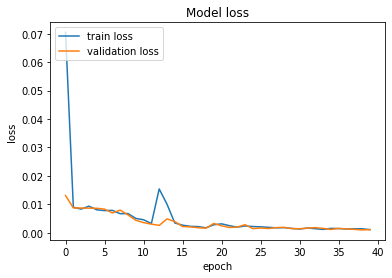

<Figure size 1440x1440 with 0 Axes>

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss','validation loss'],loc = 'upper left')
plt.figure(figsize = [20,20])
plt.show()

In [79]:
### Lets Do the prediction and check performance metrics
train_predict=trained_model.predict(x_train_multi)
test_predict=trained_model.predict(x_val_multi)

54/54 [==============================] - 3s 54ms/step


In [80]:
len(test_predict)

1706

In [81]:
len(train_predict)

1706

In [82]:
##Transformback to original form
train_predict = y_scaler.inverse_transform(train_predict)
test_predict = y_scaler.inverse_transform(test_predict)

In [83]:
train_predict

array([[79410.73  ,  6931.995 ],
       [79284.266 ,  6922.75  ],
       [79197.38  ,  6916.4497],
       ...,
       [29418.201 ,  2628.397 ],
       [26508.754 ,  2377.6199],
       [23553.73  ,  2111.0303]], dtype=float32)

In [84]:
test_predict

array([[79410.73  ,  6931.995 ],
       [79284.266 ,  6922.75  ],
       [79197.38  ,  6916.4497],
       ...,
       [29418.201 ,  2628.397 ],
       [26508.754 ,  2377.6199],
       [23553.73  ,  2111.0303]], dtype=float32)

In [85]:
l = []
for i in train_predict:
    l.append(i[0])

In [86]:
max(l)

79410.73

In [87]:
min(l)

2584.2236

In [88]:
len(train_predict)

1706

In [89]:
test_predict

array([[79410.73  ,  6931.995 ],
       [79284.266 ,  6922.75  ],
       [79197.38  ,  6916.4497],
       ...,
       [29418.201 ,  2628.397 ],
       [26508.754 ,  2377.6199],
       [23553.73  ,  2111.0303]], dtype=float32)

In [90]:
l = []
for i in test_predict:
    l.append(i[0])

In [91]:
test_predict[0][0]

79410.73

In [92]:
train_predict

array([[79410.73  ,  6931.995 ],
       [79284.266 ,  6922.75  ],
       [79197.38  ,  6916.4497],
       ...,
       [29418.201 ,  2628.397 ],
       [26508.754 ,  2377.6199],
       [23553.73  ,  2111.0303]], dtype=float32)

In [93]:
min(account_data['sales'])

0.0

In [94]:
test_predict = l

In [95]:
min(l)

2584.2236

In [96]:
testing = account_data[:-15].copy()
testing['pred_sales'] = test_predict

In [97]:
testing

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cpc,pred_sales
0,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-20,142838.120000,12583.680000,1281,29878,111,9.823326,79410.726562
1,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-21,116525.377143,10593.249643,1168,25691,85,9.069563,79284.265625
2,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-22,112508.444448,9819.077878,1158,26380,85,8.479342,79197.382812
3,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-23,113365.773241,9397.466625,1170,27465,83,8.032023,79091.750000
4,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-24,108217.496805,8806.986435,1136,27727,81,7.752629,78936.054688
...,...,...,...,...,...,...,...,...,...,...,...,...
1701,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2022-09-15,15706.403750,1339.989567,134,7697,10,9.999922,33621.312500
1702,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2022-09-16,17559.343264,1325.690958,153,7998,12,8.664647,32025.539062
1703,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2022-09-17,20873.362849,1338.424164,177,8797,15,7.561718,29418.201172
1704,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2022-09-18,19309.911794,1248.290275,167,9170,14,7.474792,26508.753906


In [98]:
testing[testing['keywordId'] == '129388728370771']

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cpc,pred_sales
0,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-20,142838.120000,12583.680000,1281,29878,111,9.823326,79410.726562
1,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-21,116525.377143,10593.249643,1168,25691,85,9.069563,79284.265625
2,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-22,112508.444448,9819.077878,1158,26380,85,8.479342,79197.382812
3,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-23,113365.773241,9397.466625,1170,27465,83,8.032023,79091.750000
4,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-01-24,108217.496805,8806.986435,1136,27727,81,7.752629,78936.054688
...,...,...,...,...,...,...,...,...,...,...,...,...
63,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-03-24,7673.235991,846.428403,76,5135,5,11.137216,35101.839844
64,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-03-25,6830.738288,740.386936,67,4973,5,11.050551,34641.195312
65,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-03-26,5919.901125,648.366732,59,4857,4,10.989267,33957.402344
66,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-03-27,5130.526853,570.111135,52,4636,3,10.963676,33197.039062


Layers are- 128-64-30


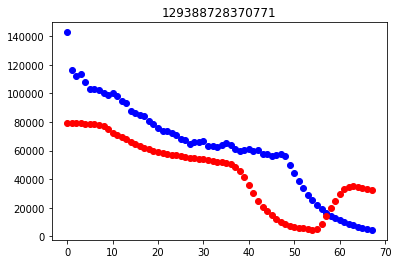

Layers are- 128-64-30


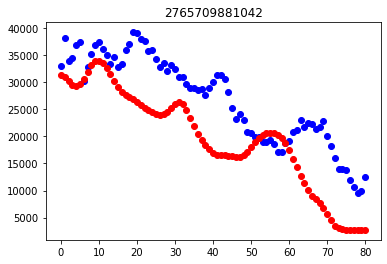

Layers are- 128-64-30


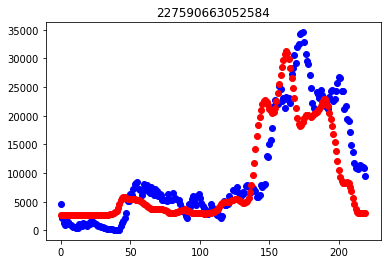

Layers are- 128-64-30


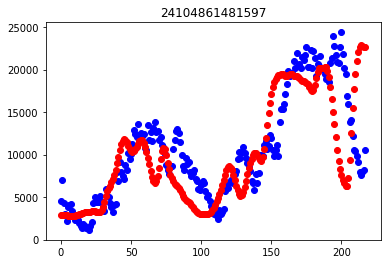

Layers are- 128-64-30


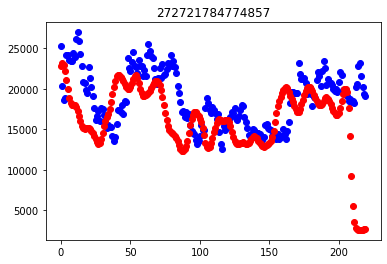

Layers are- 128-64-30


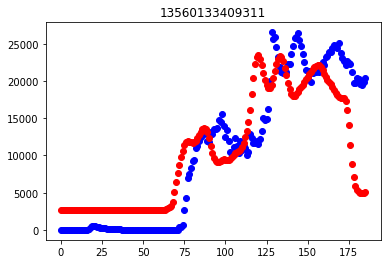

Layers are- 128-64-30


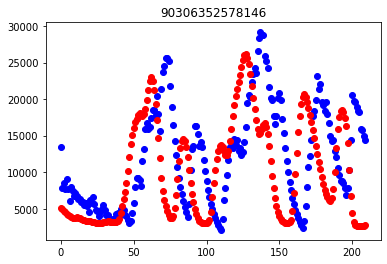

Layers are- 128-64-30


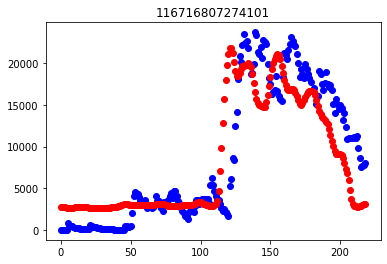

Layers are- 128-64-30


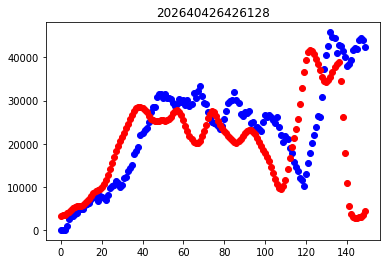

Layers are- 128-64-30


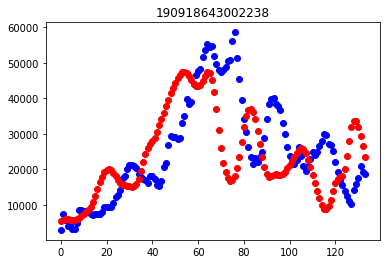

In [99]:
import matplotlib.pyplot as plt
import numpy as np
testing['keywordId'].unique()
for i in range(len(testing['keywordId'].unique())):
    def plotGraph(y_test,y_pred,s):
        if max(y_test) >= max(y_pred):
            my_range = int(max(y_test))
        else:
            my_range = int(max(y_pred))
        plt.scatter(range(len(y_test)), y_test, color='blue')
        plt.scatter(range(len(y_pred)), y_pred, color='red')
        plt.title(s)
        plt.show()
        return
    s = testing['keywordId'].unique()[i]
    print("Layers are- 128-64-30")    
    y_sales = testing[testing['keywordId'] == s]['sales']
    y_pred_sales = testing[testing['keywordId'] == s]['pred_sales']
    plotGraph(y_sales, y_pred_sales,s)

# Test

In [100]:
df = pd.read_csv("/content/drive/MyDrive/colab/account_data.csv",parse_dates = True)
a = list(df['accountId'].unique())
df = df[df['accountId']=="5ffdb895b08512986422b08c"]
df=df.copy()
df.date = pd.to_datetime(df.date)
df.sort_values(by="date", inplace=True, ignore_index=True)
account_data = df
keyword_ids = account_data["keywordId"].unique()
keywordwise_sales = account_data.groupby("keywordId")["sales"].sum()
nonzero_sales_keywords = keywordwise_sales[keywordwise_sales>0]
nonzero_sales_keywords.sort_values(ascending=False, inplace=True)
keywords_req = list(nonzero_sales_keywords.index)
keyword_ids = keywords_req[:10]
account_data =  account_data[account_data['keywordId'].isin(keyword_ids)]

account_data.reset_index(inplace = True)
account_data.sort_values(by="date", inplace=True, ignore_index=True)
account_data.drop(columns = "index",inplace = True)
account_data.sort_values(by = 'date',inplace = True)
account_data.reset_index(inplace = True)
account_data.drop(columns = "index",inplace = True)
account_data['clicks'] = account_data["clicks"].astype("int64")
account_data['impressions'] = account_data["impressions"].astype("int64")
account_data['orders'] = account_data["orders"].astype("int64")
account_data["keywordId"] = account_data["keywordId"].astype(str)
account_data["cpc"] = account_data["spend"]/account_data["clicks"] 
account_data["cpc"].interpolate("linear", inplace=True)

keyword_ids = account_data['keywordId'].unique()
keyword_wise_df = pd.DataFrame(columns = [['accountId', 'adGroupId', 'campaignId', 'keywordId', 'date', 'sales','spend', 'clicks', 'impressions', 'orders', 'cpc']])

In [101]:
frames_test = []
for i in range(len(keyword_ids)):
     a = int((30*len(account_data[account_data['keywordId'] == keyword_ids[i]]))/100)
     b = len(account_data[account_data['keywordId'] == keyword_ids[i]]) - a
     new_df_i = account_data[account_data['keywordId'] == keyword_ids[i]][b:]
     frames_test.append(new_df_i)

In [102]:
frames_test

[                    accountId        adGroupId      campaignId  \
 600  5ffdb895b08512986422b08c  175642569815727  85580432953015   
 610  5ffdb895b08512986422b08c  175642569815727  85580432953015   
 622  5ffdb895b08512986422b08c  175642569815727  85580432953015   
 625  5ffdb895b08512986422b08c  175642569815727  85580432953015   
 631  5ffdb895b08512986422b08c  175642569815727  85580432953015   
 642  5ffdb895b08512986422b08c  175642569815727  85580432953015   
 648  5ffdb895b08512986422b08c  175642569815727  85580432953015   
 656  5ffdb895b08512986422b08c  175642569815727  85580432953015   
 664  5ffdb895b08512986422b08c  175642569815727  85580432953015   
 669  5ffdb895b08512986422b08c  175642569815727  85580432953015   
 678  5ffdb895b08512986422b08c  175642569815727  85580432953015   
 689  5ffdb895b08512986422b08c  175642569815727  85580432953015   
 691  5ffdb895b08512986422b08c  175642569815727  85580432953015   
 697  5ffdb895b08512986422b08c  175642569815727  8558043295301

In [103]:
new_df_test = pd.concat(frames_test)

In [104]:
new_df_test

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cpc
600,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-04-10,813.582486,107.091706,10,2024,0,10.709171
610,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-04-11,705.103952,93.394036,9,1811,0,10.377115
622,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-04-12,611.089439,80.941411,7,1628,0,11.563059
625,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-04-13,529.610356,70.149158,6,1557,0,11.691526
631,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-04-14,458.995274,60.795888,5,1492,0,12.159178
...,...,...,...,...,...,...,...,...,...,...,...
2754,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2023-01-06,1295.111628,125.076648,10,2150,0,12.507665
2761,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2023-01-07,1122.430077,108.399762,9,1864,0,12.044418
2769,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2023-01-08,972.772734,93.946460,8,1615,0,11.743308
2776,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2023-01-09,843.069702,81.420266,7,1400,0,11.631467


In [105]:
new_df_test = pd.concat(frames_test)
new_df_test.reset_index(inplace = True)
new_df_test.drop(columns ="index", inplace = True)
new_df_test[new_df_test['cpc'] != max(new_df_test['cpc'])]
mean_cpc = sum(new_df_test[new_df_test['cpc'] != max(new_df_test['cpc'])]['cpc'])/len(new_df_test[new_df_test['cpc'] != max(new_df_test['cpc'])])
new_df_test['cpc'] = new_df_test['cpc'].astype(str)
new_df_test.replace({"cpc":{"inf":mean_cpc}},inplace = True)
new_df_test['cpc'] = new_df_test['cpc'].astype(float)
account_data_test = new_df_test
dataX_test = x_scaler.fit_transform(account_data_test[['sales','spend', 'clicks', 'impressions', 'orders','cpc']])
dataY_test = y_scaler.fit_transform(account_data_test[['sales','spend']])

def create_dataset(dataset, time_step):
    import numpy
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

x_train_multi,y_train_multi = create_dataset(dataX_test,14)
x_val_multi, y_val_multi = create_dataset(dataY_test,14)

# reshape input to be [samples, time steps, features] which is required for LSTM
x_train_multi =x_train_multi.reshape(x_train_multi.shape[0],x_train_multi.shape[1] , 1)
x_val_multi = x_val_multi.reshape(x_val_multi.shape[0],x_val_multi.shape[1] , 1)

BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [106]:
### Lets Do the prediction and check performance metrics
train_predict=trained_model.predict(x_train_multi)
test_predict=trained_model.predict(x_val_multi)

27/27 [==============================] - 1s 40ms/step


In [107]:
len(test_predict)

837

In [108]:
##Transformback to original form
train_predict = y_scaler.inverse_transform(train_predict)
test_predict = y_scaler.inverse_transform(test_predict)

In [109]:
test_predict

array([[ 732.04675,  120.29445],
       [ 729.8851 ,  119.9423 ],
       [ 728.0573 ,  119.64477],
       ...,
       [1689.0929 ,  297.36508],
       [1398.3416 ,  254.17413],
       [1151.9115 ,  209.31694]], dtype=float32)

In [110]:
l = []
for i in test_predict:
    l.append(i[0])

In [111]:
test_predict = l

In [112]:
len(l)

837

In [113]:
testing = account_data_test[15:].copy()
testing['pred_sales'] = test_predict

In [114]:
testing

,accountId,adGroupId,campaignId,keywordId,date,sales,spend,clicks,impressions,orders,cpc,pred_sales
15,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-04-25,95.099765,12.696525,1,376,0,12.696525,732.046753
16,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-04-26,82.419784,11.003653,1,333,0,11.003653,729.885071
17,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-04-27,71.430471,9.536498,0,302,0,10.748295,728.057312
18,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-04-28,61.906401,8.264964,0,280,0,10.748295,726.514832
19,5ffdb895b08512986422b08c,175642569815727,85580432953015,129388728370771,2022-04-29,53.652209,7.162968,0,249,0,10.748295,725.196777
...,...,...,...,...,...,...,...,...,...,...,...,...
847,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2023-01-06,1295.111628,125.076648,10,2150,0,12.507665,2405.567383
848,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2023-01-07,1122.430077,108.399762,9,1864,0,12.044418,2027.871216
849,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2023-01-08,972.772734,93.946460,8,1615,0,11.743308,1689.092896
850,5ffdb895b08512986422b08c,145787982816138,258268578317508,190918643002238,2023-01-09,843.069702,81.420266,7,1400,0,11.631467,1398.341553


Layers are- 128-64-60


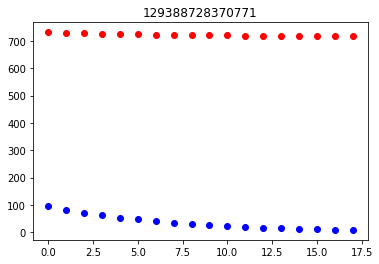

Layers are- 128-64-60


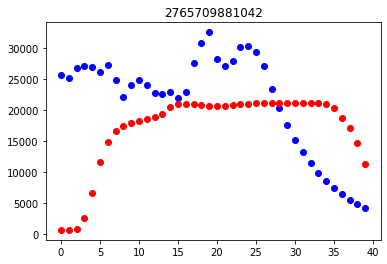

Layers are- 128-64-60


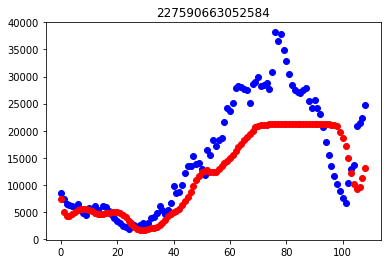

Layers are- 128-64-60


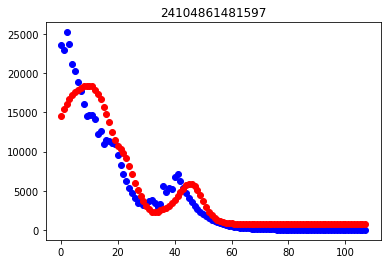

Layers are- 128-64-60


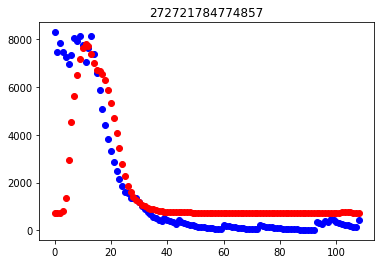

Layers are- 128-64-60


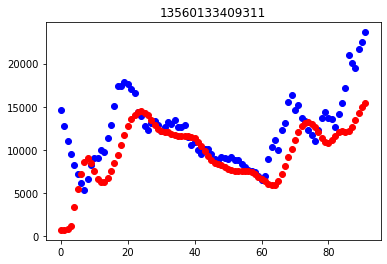

Layers are- 128-64-60


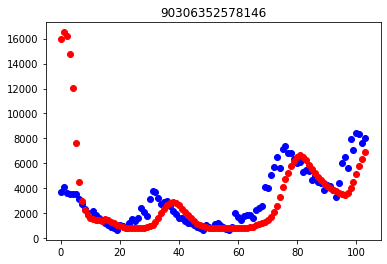

Layers are- 128-64-60


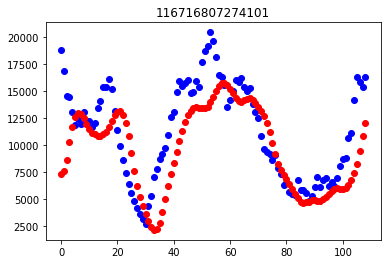

Layers are- 128-64-60


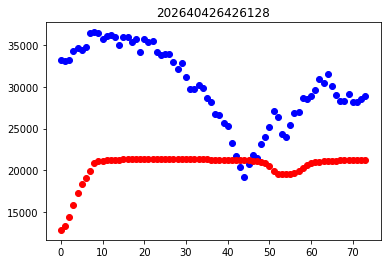

Layers are- 128-64-60


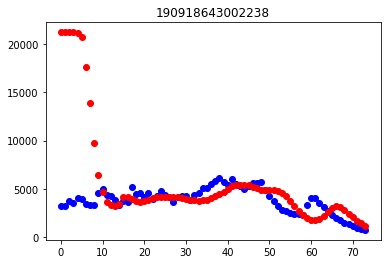

In [116]:
import matplotlib.pyplot as plt
import numpy as np
testing['keywordId'].unique()
for i in range(len(testing['keywordId'].unique())):
    def plotGraph(y_test,y_pred,s):
        if max(y_test) >= max(y_pred):
            my_range = int(max(y_test))
        else:
            my_range = int(max(y_pred))
        plt.scatter(range(len(y_test)), y_test, color='blue')
        plt.scatter(range(len(y_pred)), y_pred, color='red')
        plt.title(s)
        plt.show()
        return
    s = testing['keywordId'].unique()[i]
    print("Layers are- 128-64-60")    
    y_sales = testing[testing['keywordId'] == s]['sales']
    y_pred_sales = testing[testing['keywordId'] == s]['pred_sales']
    plotGraph(y_sales, y_pred_sales,s)

In [140]:
unique_k_ids = testing['keywordId'].unique()
dic = {'keyword':[],"rows":[]}
for i in unique_k_ids:
    data = len(testing[testing['keywordId'] == i])
    dic['keyword'].append(i)
    dic['rows'].append(data)

In [142]:
pd.DataFrame.from_dict(dic)

,keyword,rows
0,129388728370771,18
1,2765709881042,40
2,227590663052584,109
3,24104861481597,108
4,272721784774857,109
5,13560133409311,92
6,90306352578146,104
7,116716807274101,109
8,202640426426128,74
9,190918643002238,74
